In [ ]:
# !unzip /content/mm_data_pathBA_1KHz-20220221T194039Z-001.zip

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data_d = pd.read_csv('/content/mm_data_pathBA_1KHz/pathBA_SSF_dB_AP1_downsampled1Khz_win50.txt', sep=" ", header=None)
data = data_d.values

In [ ]:
data.shape

(10427, 1)

In [ ]:
data.T

array([[0.      , 0.10075 , 0.22059 , ..., 0.064074, 0.13434 , 0.      ]])

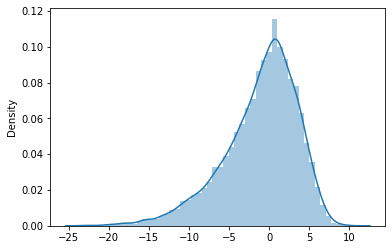

In [ ]:
sns.distplot(data, hist=True)

In [ ]:
import torch
from torch import nn

def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        # nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        sample_dim: the dimension of the samples, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, sample_dim=data.shape[0], hidden_dim=64):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            get_generator_block(hidden_dim * 8, hidden_dim * 16),
            nn.Linear(hidden_dim * 16, sample_dim)
            # nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen


In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim, device=device)

In [ ]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=.2)
    )

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        sample_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, sample_dim=data.shape[0], hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(sample_dim, hidden_dim * 8),
            get_discriminator_block(hidden_dim * 8, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [ ]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 20000
z_dim = 64
display_step = 100
# batch_size = 128
lr = 0.00002
beta_1 = 0.5 
beta_2 = 0.999

# # Load MNIST dataset as tensors
# dataloader = DataLoader(
#     MNIST('.', download=False, transform=transforms.ToTensor()),
#     batch_size=batch_size,
#     shuffle=True)

### DO NOT EDIT ###
device = 'cuda'

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     Steps:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.

    noise = get_noise(n_samples=num_images, z_dim=z_dim, device=device)
    generator = gen(noise)
    disc_fake = disc(generator.detach())
    disc_fake_loss = criterion(disc_fake, torch.zeros_like(disc_fake))
    disc_real = disc(real)
    disc_real_loss = criterion(disc_real, torch.ones_like(disc_real))
    disc_loss = (disc_fake_loss + disc_real_loss)/2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    noise = get_noise(n_samples=num_images, z_dim=z_dim, device=device)
    generator = gen(noise)
    disc_pred = disc(generator)
    gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
    #### END CODE HERE ####
    return gen_loss

In [ ]:
## Set up directories
paths = ['ims', 
            'ims/epochs/', 
        ]
for i in paths:
    if not os.path.exists(i):
        os.makedirs(i)

In [ ]:
def show_tensor_kde(tensor_fake, tensor_real, step):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    tensor_fake_unflat = tensor_fake.detach().cpu().numpy()
    tensor_real_unflat = tensor_real.detach().cpu().numpy()
    sns.distplot(tensor_fake_unflat, label='GAN', hist=True)
    # plt.show()
    sns.distplot(tensor_real_unflat, label='Real Distribution', color='red', hist=True)
    plt.ylim(0, .12)
    plt.legend()
    plt.savefig(f'ims/epochs/k_u.{step:03d}.png')
    plt.show()

Step 100: Generator loss: 0.7018042266368868, discriminator loss: 0.372030963897705


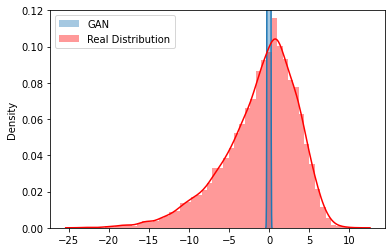

Step 200: Generator loss: 0.7447886937856674, discriminator loss: 0.32744334131479264


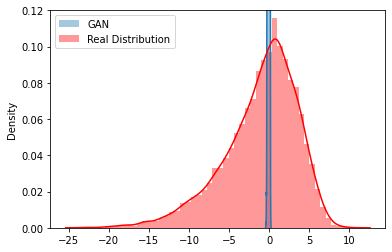

Step 300: Generator loss: 0.7602830088138579, discriminator loss: 0.3251314821839332


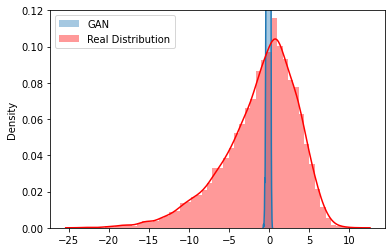

Step 400: Generator loss: 0.7371529185771939, discriminator loss: 0.3584379360079765


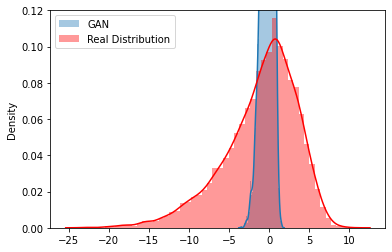

Step 500: Generator loss: 0.6590294820070267, discriminator loss: 0.48099403172731403


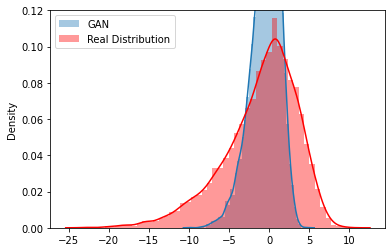

Step 600: Generator loss: 0.690383664667606, discriminator loss: 0.574496639072895


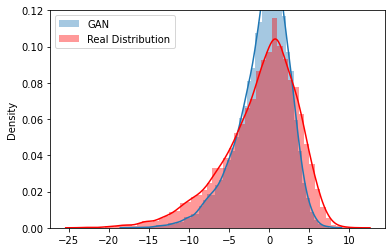

Step 700: Generator loss: 0.7424777698516849, discriminator loss: 0.6325803810358045


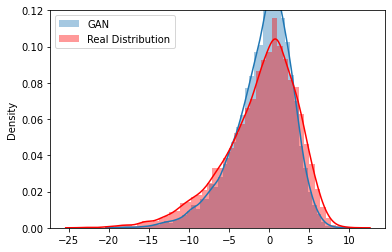

Step 800: Generator loss: 0.7986615625023842, discriminator loss: 0.6663124567270281


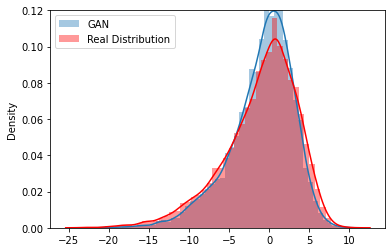

Step 900: Generator loss: 0.7958584031462672, discriminator loss: 0.6660061711072922


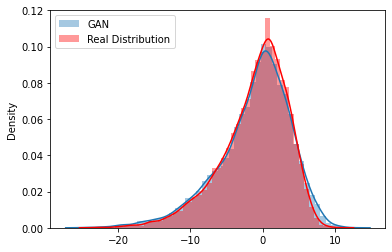

Step 1000: Generator loss: 0.8354393884539602, discriminator loss: 0.6832959550619124


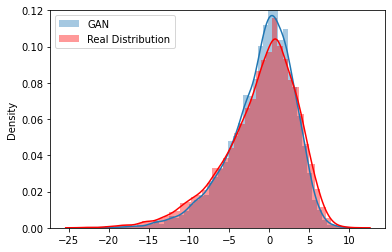

Step 1100: Generator loss: 0.8256370085477832, discriminator loss: 0.6770679819583891


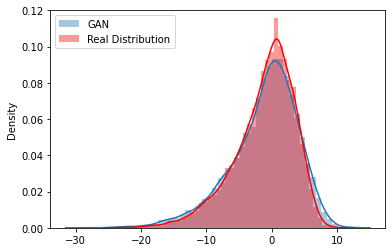

Step 1200: Generator loss: 0.8154117333889009, discriminator loss: 0.6851390188932419


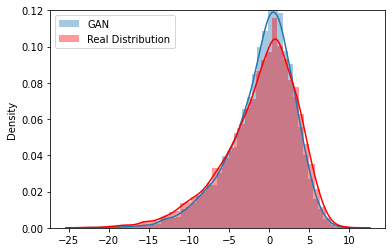

Step 1300: Generator loss: 0.8380185133218765, discriminator loss: 0.6928193521499633


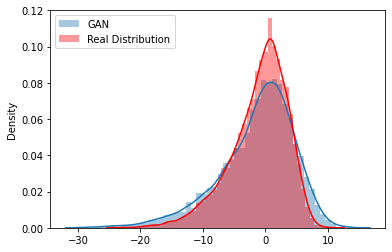

Step 1400: Generator loss: 0.8283475238084792, discriminator loss: 0.687832658290863


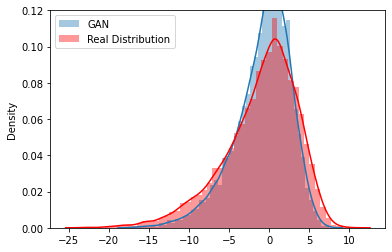

Step 1500: Generator loss: 0.811519381403923, discriminator loss: 0.703207522630692


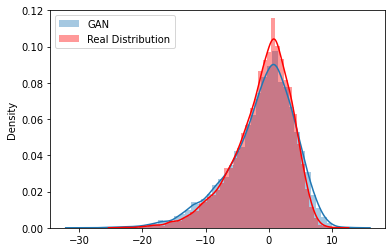

Step 1600: Generator loss: 0.8250388020277023, discriminator loss: 0.6983248186111445


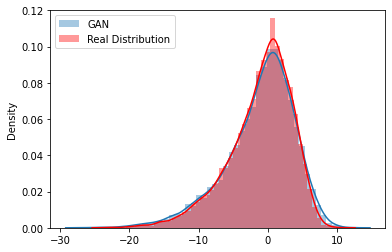

Step 1700: Generator loss: 0.8374741941690442, discriminator loss: 0.6909341698884962


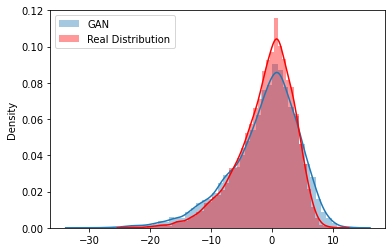

Step 1800: Generator loss: 0.81050891160965, discriminator loss: 0.6998811858892442


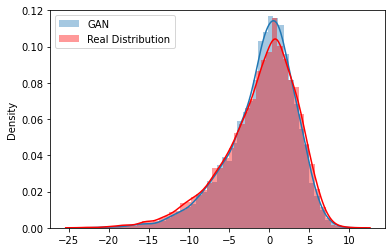

Step 1900: Generator loss: 0.8295325744152068, discriminator loss: 0.6872864204645157


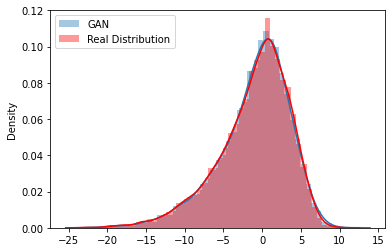

Step 2000: Generator loss: 0.8220558434724807, discriminator loss: 0.6819193953275678


KeyboardInterrupt: ignored

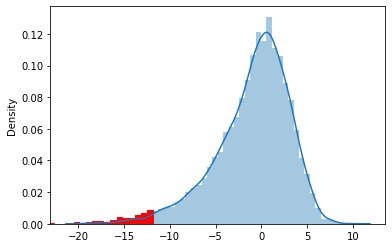

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
      # print('epoch: ', cur_step)
    # Dataloader returns the batches
    # for real, _ in tqdm(dataloader):
      real = data.T
      
      cur_batch_size = len(real)

      # Flatten the batch of real images from the dataset
      real = torch.from_numpy(real).float().to(device)

      ### Update discriminator ###
      # Zero out the gradients before backpropagation
      disc_opt.zero_grad()

      # Calculate discriminator loss
      disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

      # Update gradients
      disc_loss.backward(retain_graph=True)

      # Update optimizer
      disc_opt.step()

      # For testing purposes, to keep track of the generator weights
      if test_generator:
          old_generator_weights = gen.gen[0][0].weight.detach().clone()

      ### Update generator ###
      #     Hint: This code will look a lot like the discriminator updates!
      #     These are the steps you will need to complete:
      #       1) Zero out the gradients.
      #       2) Calculate the generator loss, assigning it to gen_loss.
      #       3) Backprop through the generator: update the gradients and optimizer.
      #### START CODE HERE ####
      gen_opt.zero_grad()
      gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
      gen_loss.backward(retain_graph=True)
      gen_opt.step()
      #### END CODE HERE ####

      # For testing purposes, to check that your code changes the generator weights
      if test_generator:
          try:
              assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
              assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
          except:
              error = True
              print("Runtime tests have failed")

      # Keep track of the average discriminator loss
      mean_discriminator_loss += disc_loss.item() / display_step

      # Keep track of the average generator loss
      mean_generator_loss += gen_loss.item() / display_step

      ### Visualization code ###
      if cur_step % display_step == 0 and cur_step > 0:
          print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
          fake_noise = get_noise(cur_batch_size, z_dim, device=device)
          fake = gen(fake_noise)
          show_tensor_kde(tensor_fake=fake, tensor_real=real, step=cur_step)
          # show_tensor_kde(real)
          mean_generator_loss = 0
          mean_discriminator_loss = 0
      cur_step += 1

os.system(f'ffmpeg -r 20 -i ims/epochs/k_u.%03d.png'
              f' -crf 15 ims/epochs/k_u.mp4')

In [ ]:
cur_batch_size

1

In [ ]:
fake_noise.shape

torch.Size([1, 64])

In [ ]:
fake = gen(fake_noise)

In [ ]:
fake.view(-1).shape

torch.Size([10427])

In [ ]:
fake

In [ ]:
real

In [ ]:
real.shape

In [ ]:
tensor_fake_unflat

In [ ]:
tensor_real_unflat

In [ ]:
fake_noise = get_noise(20000, z_dim, device=device)

In [ ]:
fake_noise.shape

In [ ]:
fake = gen(fake_noise)

In [ ]:
fake.shape

In [ ]:
fake_noise = get_noise(20000, z_dim, device=device)
fake = gen(fake_noise)
tensor_fake_unflat = fake.view(-1).detach().cpu().numpy()
tensor_real_unflat = real.detach().cpu().numpy()
sns.distplot(tensor_fake_unflat, label='GAN', hist=True)
# plt.show()
sns.distplot(tensor_real_unflat, label='Real Distribution', color='red', hist=True)
plt.ylim(0, .12)
plt.legend()
plt.savefig(f'ims/epochs/k_u.{step:03d}.png')
plt.show()

In [ ]:
os.system(f'ffmpeg -r 20 -i ims/epochs/k_u.%03d.png'
              f' -crf 15 ims/epochs/k_u.mp4')

In [ ]:
!zip -r "/content/files.zip" "/content/ims/"


In [ ]:
fake